In [1]:
# Imports

In [2]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
import json
import time

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import backend as K
print('keras version ', keras.__version__)

from IPython.display import clear_output    

keras version  2.4.3


In [3]:
!mkdir -p dataset/sisfall
!wget https://www.dropbox.com/s/vvxd7whyn76oiua/xvalue.zip  -O ./dataset/sisfall/xvalue.zip 
!unzip ./dataset/sisfall/xvalue.zip   -d ./dataset/sisfall/
!rm ./dataset/sisfall/xvalue.zip
clear_output(wait=True)
print('finished')

finished


In [ ]:
!mkdir -p /content/Drive/sisfall
!wget https://www.dropbox.com/s/vvxd7whyn76oiua/xvalue.zip  -O ./content/Drive/sisfall/xvalue.zip 
!unzip ./content/Drive/sisfall/xvalue.zip   -d ./content/Drive/sisfall/
!rm ./content/Drive/sisfall/xvalue.zip
clear_output(wait=True)
print('finished')


finished


In [4]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/dataset')
clear_output(wait=True)
print('finished')

finished


# Functions

In [24]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,cmap="coolwarm",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

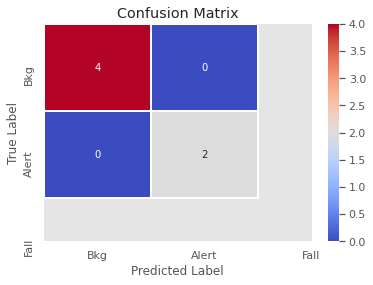

In [29]:
show_confusion_matrix([0,0,0,0,1,1],[0,0,0,0,1,1])

In [7]:
LABELS = ["Bkg","Alert","Fall"]
#xvalue = np.load('./content/Drive/sisfall/xvalue.npy')
xvalue = np.load('/content/dataset/sisfall/xvalue.npy')
#yvalue = pd.read_csv('./dataset/sisfall/yvalue.csv')
yvalue = pd.read_csv('/content/dataset/sisfall/yvalue.csv')

print(f'shape xvalue : {xvalue.shape}')
print(f'shape yvalue : {yvalue.shape}')
yvalue.head(1)

shape xvalue : (116988, 256, 9)
shape yvalue : (116988, 3)


,Target,subId,activiteId
0,0,SA01,D01


In [8]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot') # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

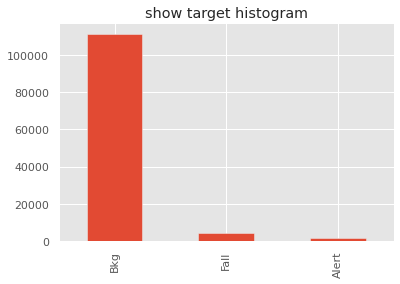

In [9]:
ax = yvalue['Target'].value_counts().plot(kind='bar',title='show target histogram')
ax.set_xticks(range(0,3))
ax.set_xticklabels(['Bkg','Fall','Alert'])
plt.show()

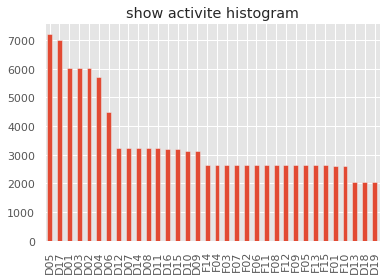

In [10]:
ax = yvalue['activiteId'].value_counts().plot(kind='bar',title='show activite histogram')
plt.show()

In [11]:
yvalue = yvalue['Target']
yvalue.head(1)

0    0
Name: Target, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(xvalue, yvalue, test_size = 0.20, random_state = 0)
print(f'Shape of train feature is : {X_train.shape}')
print(f'Shape of train target is : {y_train.shape}')
print(f'Shape of test feature is : {X_test.shape}')
print(f'Shape of test target is : {y_test.shape}')

Shape of train feature is : (93590, 256, 9)
Shape of train target is : (93590,)
Shape of test feature is : (23398, 256, 9)
Shape of test target is : (23398,)


## reshape

In [13]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = len(LABELS)
print('num_classes: ' + str(num_classes))
print('num_sensors: '+  str(num_sensors))
print('num_time_periods: ' + str(num_time_periods))

num_classes: 3
num_sensors: 9
num_time_periods: 256


In [ ]:
## only use for cnn 
input_shape = (num_time_periods * num_sensors)
X_train = X_train.reshape(X_train.shape[0], input_shape)
X_test = X_test.reshape(X_test.shape[0], input_shape)
print(X_train.shape)
print(X_test.shape)

(93590, 2304)
(23398, 2304)


##  Convert type for Keras otherwise Keras cannot process the data

In [16]:
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

## Convert lable to one-hot

In [17]:
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_train[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

## **Define our metrics:**

In [18]:
def recall(y_true, y_pred):    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall   
    
def precision(y_true, y_pred):        
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f_score(y_true, y_pred):
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    return 2*((_precision*_recall)/(_precision+_recall+K.epsilon()))

def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n
    
def TP_bkg(y_true, y_pred):
    return TP(y_true[0], y_pred[0])
def TP_alert(y_true, y_pred):
    return TP(y_true[1], y_pred[1])
def TP_fall(y_true, y_pred):
    return TP(y_true[2], y_pred[2])

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def TN_bkg(y_true, y_pred):
    return TN(y_true[0], y_pred[0])
def TN_alert(y_true, y_pred):
    return TN(y_true[1], y_pred[1])
def TN_fall(y_true, y_pred):
    return TN(y_true[2], y_pred[2])
  
def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n
def FP_bkg(y_true, y_pred):
    return FP(y_true[0], y_pred[0])
def FP_alert(y_true, y_pred):
    return FP(y_true[1], y_pred[1])
def FP_fall(y_true, y_pred):
    return FP(y_true[2], y_pred[2])

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN
    return tn/n

def FN_bkg(y_true, y_pred):
    return FN(y_true[0], y_pred[0])

def FN_alert(y_true, y_pred):
    return FN(y_true[1], y_pred[1])
    
def FN_fall(y_true, y_pred):
    return FN(y_true[2], y_pred[2])

## Build our model
### CNN

In [ ]:
model_m = Sequential()
model_m.add(Reshape((num_time_periods, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(num_time_periods, num_sensors)))
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(1920, activation='relu'))
model_m.add(Dense(512, activation='relu'))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 256, 9)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 254, 64)           1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 254, 64)           256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 82, 64)            12352     
_________________________________________________________________
batch_normalization_7 (Batch (None, 82, 64)            256       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 27, 64)           

## Fit CNN the model

In [ ]:
start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='./drive/My Drive/cnn_best_model.h5',
                                                  monitor='val_loss', save_best_only=True)]#keras.callbacks.EarlyStopping(monitor='acc', patience=1)]

optimizer = keras.optimizers.Adam(clipvalue=0.5)
model_m.compile(loss='categorical_crossentropy',
                optimizer=optimizer, metrics=['acc',f_score,TP_bkg,TN_bkg,FP_bkg,FN_bkg,TP_alert,TN_alert,FP_alert,FN_alert,TP_fall,TN_fall,FP_fall,FN_fall])    # accuracy

BATCH_SIZE = 64
EPOCHS = 40

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

json.dump(history.history, open("./drive/My Drive/history_cnn.pkl", "w"))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/40
1170/1170 [==============================] - 113s 97ms/step - loss: 0.0964 - acc: 0.9716 - f_score: 0.9716 - TP_bkg: 0.3228 - TN_bkg: 0.6578 - FP_bkg: 0.0088 - FN_bkg: 0.0105 - TP_alert: 0.3254 - TN_alert: 0.6610 - FP_alert: 0.0057 - FN_alert: 0.0080 - TP_fall: 0.3256 - TN_fall: 0.6604 - FP_fall: 0.0063 - FN_fall: 0.0077 - val_loss: 0.0714 - val_acc: 0.9769 - val_f_score: 0.9774 - val_TP_bkg: 0.3254 - val_TN_bkg: 0.6610 - val_FP_bkg: 0.0057 - val_FN_bkg: 0.0080 - val_TP_alert: 0.3242 - val_TN_alert: 0.6587 - val_FP_alert: 0.0080 - val_FN_alert: 0.0091 - val_TP_fall: 0.3299 - val_TN_fall: 0.6655 - val_FP_fall: 0.0011 - val_FN_fall: 0.0034
Epoch 2/40
1170/1170 [==============================] - 122s 104ms/step - loss: 0.0778 - acc: 0.9763 - f_score: 0.9764 - TP_bkg: 0.3222 - TN_bkg: 0.6587 - FP_bkg: 0.0080 - FN_bkg: 0.0111 - TP_alert: 0.3234 - TN_alert: 0.6601 - FP_alert: 0.0066 - FN_alert: 0.0100 - TP_fall: 0.3236 - TN_fall: 0.6595 - FP_fall: 0.0071 - FN_fall: 0.0097 - val_lo

## Build our model
### LSTM

In [43]:
model_m = keras.Sequential()
model_m.add(Dense(32, activation='relu', input_shape=(num_time_periods, num_sensors)))
model_m.add(BatchNormalization())
model_m.add(Dropout(0.5))
model_m.add(LSTM(32, activation='relu', return_sequences=True))
model_m.add(Dropout(0.5))
model_m.add(LSTM(32, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(Dense(512))
model_m.add(Dense(num_classes, activation='softmax'))
model_m.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256, 32)           320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 32)           128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 256, 32)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 256, 32)           8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256, 32)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)               

## Fit LSTM the model

In [46]:
start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='./drive/My Drive/lstm_best_model.h5',
                                                  monitor='val_loss', save_best_only=True)]#keras.callbacks.EarlyStopping(monitor='acc', patience=1)]

optimizer = keras.optimizers.Adam(clipvalue=0.5)
model_m.compile(loss='categorical_crossentropy',
                optimizer=optimizer, metrics=['acc',f_score,TP_bkg,TN_bkg,FP_bkg,FN_bkg,TP_alert,TN_alert,FP_alert,FN_alert,TP_fall,TN_fall,FP_fall,FN_fall])    # accuracy

BATCH_SIZE = 64
EPOCHS = 40

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

json.dump(history.history, open("./drive/My Drive/history_lstm.pkl", "w"))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/40
1170/1170 [==============================] - 311s 266ms/step - loss: 1575834.2500 - acc: 0.9573 - f_score: 0.9574 - TP_bkg: 0.3202 - TN_bkg: 0.6541 - FP_bkg: 0.0125 - FN_bkg: 0.0131 - TP_alert: 0.3199 - TN_alert: 0.6533 - FP_alert: 0.0134 - FN_alert: 0.0134 - TP_fall: 0.3222 - TN_fall: 0.6558 - FP_fall: 0.0108 - FN_fall: 0.0111 - val_loss: 0.1556 - val_acc: 0.9608 - val_f_score: 0.9609 - val_TP_bkg: 0.3208 - val_TN_bkg: 0.6553 - val_FP_bkg: 0.0114 - val_FN_bkg: 0.0125 - val_TP_alert: 0.3197 - val_TN_alert: 0.6530 - val_FP_alert: 0.0137 - val_FN_alert: 0.0137 - val_TP_fall: 0.3185 - val_TN_fall: 0.6519 - val_FP_fall: 0.0148 - val_FN_fall: 0.0148
Epoch 2/40
1170/1170 [==============================] - 310s 265ms/step - loss: 0.1410 - acc: 0.9633 - f_score: 0.9636 - TP_bkg: 0.3191 - TN_bkg: 0.6547 - FP_bkg: 0.0120 - FN_bkg: 0.0142 - TP_alert: 0.3219 - TN_alert: 0.6567 - FP_alert: 0.0100 - FN_alert: 0.0114 - TP_fall: 0.3194 - TN_fall: 0.6533 - FP_fall: 0.0134 - FN_fall: 0.0140 -

KeyboardInterrupt: ignored

# **ConvLSTM**

In [68]:
model_m = keras.Sequential()
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(num_time_periods, num_sensors)))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(LSTM(32, activation='relu', return_sequences=True))
model_m.add(Dropout(0.5))
model_m.add(LSTM(32, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(Dense(512))
model_m.add(Dense(num_classes, activation='softmax'))
model_m.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 254, 64)           1792      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 127, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 125, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 60, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 28, 64)          

In [ ]:
start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='./drive/My Drive/convlstm_best_model.h5',
                                                  monitor='val_loss', save_best_only=True)]#keras.callbacks.EarlyStopping(monitor='acc', patience=1)]

optimizer = keras.optimizers.Adam(clipvalue=0.5)
model_m.compile(loss='categorical_crossentropy',
                optimizer=optimizer, metrics=['acc',f_score,TP_bkg,TN_bkg,FP_bkg,FN_bkg,TP_alert,TN_alert,FP_alert,FN_alert,TP_fall,TN_fall,FP_fall,FN_fall])    # accuracy

BATCH_SIZE = 64
EPOCHS = 100

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

json.dump(history.history, open("./drive/My Drive/history_covnlstm.pkl", "w"))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
 719/1170 [=================>............] - ETA: 31s - loss: 0.0622 - acc: 0.9807 - f_score: 0.9810 - TP_bkg: 0.3255 - TN_bkg: 0.6611 - FP_bkg: 0.0056 - FN_bkg: 0.0079 - TP_alert: 0.3250 - TN_alert: 0.6597 - FP_alert: 0.0070 - FN_alert: 0.0083 - TP_fall: 0.3268 - TN_fall: 0.6611 - FP_fall: 0.0056 - FN_fall: 0.0065

# **Show result**

In [47]:
model_m = keras.models.load_model("./drive/My Drive/lstm_best_model.h5",
                                  custom_objects={"f_score":f_score,"TP_bkg":TP_bkg,"TN_bkg":TN_bkg,
                                  "FP_bkg":FP_bkg,"FN_bkg":FN_bkg,"TP_alert":TP_alert,
                                  "TN_alert":TN_alert,"FP_alert":FP_alert,"FN_alert":FN_alert,
                                  "TP_fall":TP_fall,"TN_fall":TN_fall,"FP_fall":FP_fall,"FN_fall":FN_fall})                                  

In [ ]:
history_dict = json.load(open("./drive/My Drive/history.pkl", 'r'))

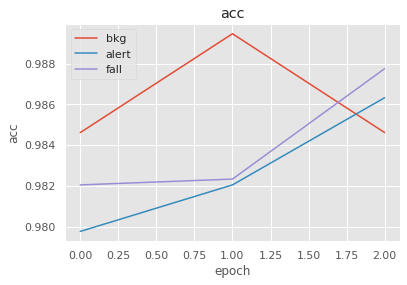

In [ ]:
def accurace(tp,tn,fp,fn):
  return (np.array(tp)+ np.array(tn)) / (np.array(tp)+np.array(tn)+np.array(fn)+np.array(fp))
acc_bkg = accurace(history_dict['TP_bkg'] ,history_dict['TN_bkg'] ,history_dict['FP_bkg'] ,history_dict['FN_bkg'] )
acc_alert = accurace(history_dict['TP_alert'] ,history_dict['TN_alert'] ,history_dict['FP_alert'] ,history_dict['FN_alert'])
acc_fall = accurace(history_dict['TP_fall'] ,history_dict['TN_fall'] ,history_dict['FP_fall'] ,history_dict['FN_fall'] )
plt.plot(acc_bkg)
plt.plot(acc_alert)
plt.plot(acc_fall)
plt.title('acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['bkg', 'alert','fall'], loc='upper left')
plt.show()

sensivity bkg : 99.65812180229717
sensivity alert : 99.82906091129749
sensivity fall : 98.5470170646191
avg of sensivity : 99.34473325940458


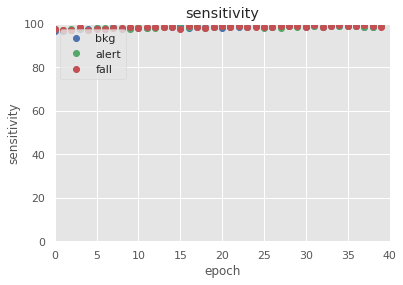

In [ ]:
def sensitivity(tp,tn,fp,fn):
  return np.array(tp) / (np.array(tp)+np.array(fn)) * 100
sen_bkg = sensitivity(history_dict['TP_bkg'] ,history_dict['TN_bkg'] ,history_dict['FP_bkg'] ,history_dict['FN_bkg'] )
print(f'sensivity bkg : {sen_bkg[-1]}')
sen_alert = sensitivity(history_dict['TP_alert'] ,history_dict['TN_alert'] ,history_dict['FP_alert'] ,history_dict['FN_alert'])
print(f'sensivity alert : {sen_alert[-1]}')
sen_fall = sensitivity(history_dict['TP_fall'] ,history_dict['TN_fall'] ,history_dict['FP_fall'] ,history_dict['FN_fall'] )
print(f'sensivity fall : {sen_fall[-1]}')
print(f'avg of sensivity : {(sen_bkg[-1] + sen_alert[-1]+ sen_fall[-1])/3}')
plt.plot(sen_bkg,'bo')
plt.plot(sen_alert,'go')
plt.plot(sen_fall,'ro')
plt.title('sensitivity')
plt.ylabel('sensitivity')
plt.xlabel('epoch')
plt.legend(['bkg', 'alert','fall'], loc='upper left')
plt.axis([0, 40, 0, 100])
plt.show()

specificity bkg : 99.65812180229717
specificity alert : 99.82906091129749
specificity fall : 98.5470170646191
avg of specificity : 99.75783626123983


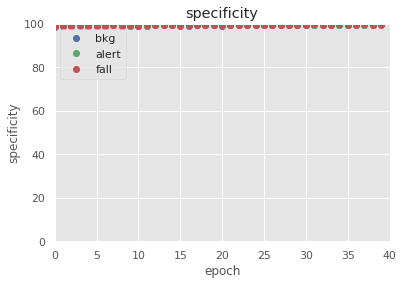

In [ ]:
def specificity(tp,tn,fp,fn):
  return np.array(tn) / (np.array(tn)+np.array(fp)) * 100
sep_bkg = specificity(history_dict['TP_bkg'] ,history_dict['TN_bkg'] ,history_dict['FP_bkg'] ,history_dict['FN_bkg'] )
print(f'specificity bkg : {sen_bkg[-1]}')
sep_alert = specificity(history_dict['TP_alert'] ,history_dict['TN_alert'] ,history_dict['FP_alert'] ,history_dict['FN_alert'])
print(f'specificity alert : {sen_alert[-1]}')
sep_fall = specificity(history_dict['TP_fall'] ,history_dict['TN_fall'] ,history_dict['FP_fall'] ,history_dict['FN_fall'] )
print(f'specificity fall : {sen_fall[-1]}')
print(f'avg of specificity : {(sep_bkg[-1] + sep_alert[-1]+ sep_fall[-1])/3}')
plt.plot(sep_bkg,'bo')
plt.plot(sep_alert,'go')
plt.plot(sep_fall,'ro')
plt.title('specificity')
plt.ylabel('specificity')
plt.xlabel('epoch')
plt.legend(['bkg', 'alert','fall'], loc='upper left')
plt.axis([0, 40, 0, 100])
plt.show()

In [48]:
prep = model_m.predict(X_test)
prep2 = prep.copy()

In [51]:
prep3 = [i == max(i) for i in prep2]
p = [i[0] for i in prep3]
t = [i[0]==1 for i in y_test]
bkgacc = (sum([p[i] == t[i] for i in range(0,len(p))]) / len(p)) * 100
p = [i[1] for i in prep3]
t = [i[1]==1 for i in y_test]
alartacc = (sum([p[i] == t[i] for i in range(0,len(p))]) / len(p)) * 100
p = [i[2] for i in prep3]
t = [i[2]==1 for i in y_test]
fallacc = (sum([p[i] == t[i] for i in range(0,len(p))]) / len(p)) * 100
print(f'bkg acc: {bkgacc}')
print(f'alart acc: {alartacc}')
print(f'fall acc: {fallacc}')
print(f'mean: {(bkgacc + alartacc + fallacc)/3}')

bkg acc: 96.13214804684162
alart acc: 98.6964697837422
fall acc: 97.41003504573041
mean: 97.41288429210475


In [52]:
score = model_m.evaluate(X_test, y_test, verbose=2,batch_size=64)

print("\nAccuracy on test data: %0.4f" % (score[1]*100))
print("\nLoss on test data: %0.4f" % score[0])

366/366 - 19s - loss: 0.1348 - acc: 0.9612 - f_score: 0.9610 - TP_bkg: 0.3215 - TN_bkg: 0.6557 - FP_bkg: 0.0109 - FN_bkg: 0.0118 - TP_alert: 0.3279 - TN_alert: 0.6612 - FP_alert: 0.0055 - FN_alert: 0.0055 - TP_fall: 0.3179 - TN_fall: 0.6539 - FP_fall: 0.0128 - FN_fall: 0.0155

Accuracy on test data: 96.1193

Loss on test data: 0.1348


In [ ]:
print("\n--- Confusion matrix for test data ---\n")
y_pred_test = model_m.predict(X_test_cnn)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_cnn_en, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))